In [173]:
import tensorflow as tf
import sys
sys.path.append('..')
from AutoEncoder.pipeline import make_dataset
import os
import matplotlib.pyplot as plt
import showit
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import glob
import io

# Set Working Directories

In [174]:
working_dir = os.path.join('/home/scott/final_model')
models_dir = os.path.join(working_dir, 'model')
train_tfrecords_dir = os.path.join(working_dir, 'tfrecords/train')
valid_tfrecords_dir = os.path.join(working_dir, 'tfrecords/valid')

In [175]:
list_of_model_paths = glob.glob(models_dir+'/*/model/*.h5')

In [176]:
list_of_model_paths

['/home/scott/final_model/model/pneumothorax/model/pneumothorax_model.h5',
 '/home/scott/final_model/model/atelectasis/model/atelectasis.h5',
 '/home/scott/final_model/model/edema/model/edema.h5']

# Load Train and Valid Data Sets and Inspect

In [177]:
train_data = make_dataset(train_tfrecords_dir)
valid_data = make_dataset(valid_tfrecords_dir)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /home/scott/final_model/tfrecords/train/*.tfrecord'

In [178]:
single_train_example = train_data.take(1)
for img, label, cls in single_train_example:
    train_image = img
    train_label = label
    train_class = cls
    
train_image = train_image[0]
train_label = train_label[0]
train_class = train_class[0]


showit.image(train_image)
plt.show()

plt.figure()
plt.bar(range(len(train_label)), train_label)
plt.xlabel('Class #')
plt.title('Class Label')
plt.xticks(range(14))
plt.text(3, 0.6, str(train_class.numpy()))
plt.show()

NotFoundError: /home/scott/final_model/tfrecords/train/pneumothorax_train_01of05.tfrecord; No such file or directory [Op:IteratorGetNextSync]

In [ ]:
single_valid_example = valid_data.take(1)
for img, label, cls in single_valid_example:
    valid_image = img
    valid_label = label
    valid_class = cls
    
valid_image = valid_image[0]
valid_label = valid_label[0]
valid_class = valid_class[0]


showit.image(valid_image)
plt.show()

plt.figure()
plt.bar(range(len(valid_label)), valid_label)
plt.xlabel('Class #')
plt.title('Class Label')
plt.xticks(range(14))
plt.text(3, 0.6, str(valid_class.numpy()))
plt.show()

In [179]:
print(train_label)
print(valid_label)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]], shape=(10, 14), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(14,), dtype=float32)


# Restore Inception ResNet V2 From Keras

In [180]:
inception_res = InceptionResNetV2(include_top=False,
                                  weights='imagenet',
                                  input_shape=(299,299,3))

inception_res.trainable = False

# Restore AutoEncoders

In [181]:
from tensorflow.keras.models import load_model

def rename_layers(model, ext):
    for layer in model.layers:
        layer._name = layer.name + ext

def restore_models(paths):
    restored_models = []
    for pos, path in enumerate(paths):
        model = load_model(path)
        model._name = 'AE_{}'.format(pos)
        rename_layers(model, str(pos))
        
        model.trainable=False
        
        restored_models.append(model)
        
    return restored_models

In [182]:
AE_models = restore_models(list_of_model_paths)

In [42]:
AE_models[0].summary()

Model: "AE_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential0 (Sequential)     (None, 150, 150, 32)      1536      
_________________________________________________________________
sequential_10 (Sequential)   (None, 75, 75, 32)        16384     
_________________________________________________________________
sequential_20 (Sequential)   (None, 38, 38, 32)        16384     
_________________________________________________________________
sequential_30 (Sequential)   (None, 19, 19, 16)        8192      
_________________________________________________________________
flatten0 (Flatten)           (None, 5776)              0         
_________________________________________________________________
dense0 (Dense)               (None, 1200)              6932400

In [ ]:
tf.keras.utils.plot_model(model=AE_models[0],
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='LR',
                         dpi=96)

# Build Cheat Sheet

In [183]:
def cheatsheet():
    inputs = tf.keras.layers.Input(shape=[299,299,3])
    
    reconstruction_differences = []
    
    for model in AE_models:
        x = model(inputs)
        diff = tf.math.subtract(inputs, x)
        reconstruction_differences.append(diff)
        
    cheat_sheet = tf.keras.layers.Concatenate()(reconstruction_differences)
    return tf.keras.Model(inputs=inputs, outputs=cheat_sheet,name='cheatsheet')

In [44]:
for img, label, cls in single_train_example:
    train_image = img
    train_label = label
    train_class = cls

In [184]:
cheatsheet_generator = cheatsheet()

In [185]:
cheat_sheet = cheatsheet_generator(train_image)
cheat_sheet = tf.keras.layers.Flatten()(cheat_sheet)

In [186]:
transfer = inception_res(train_image)
transfer = tf.keras.layers.Flatten()(transfer)

In [187]:
model_input_ = tf.keras.layers.Concatenate()([cheat_sheet, transfer])

In [190]:
train_image.shape

TensorShape([10, 299, 299, 3])

In [12]:
def inception_cheat():
    result = tf.keras.Sequential()
    
    result.add(inception_res)
    result.add()

In [50]:
def Model1(transfer_model, cheatsheet_generator):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.layers.Input(shape=[299,299,3])
    
    transfer = tf.keras.Sequential([transfer_model])
    cheat = cheatsheet_generator()
    
    x_trans = transfer(inputs)
    x_trans = tf.keras.layers.Flatten()(x_trans)
    x_cheat = cheat(inputs)
    x_cheat = tf.keras.layers.Flatten()(x_cheat)
    
    x = tf.keras.layers.Concatenate()([x_trans, x_cheat])
    
    
    
    x = tf.keras.layers.Dense(units=100, 
                              activation='relu', 
                              use_bias=True, 
                              kernel_initializer=initializer, 
                              bias_initializer=initializer)(x)
    
    x = tf.keras.layers.Dense(units=50, 
                              activation='relu', 
                              use_bias=True, 
                              kernel_initializer=initializer, 
                              bias_initializer=initializer)(x)
    
    x = tf.keras.layers.Dense(units=50, 
                              activation='sigmoid', 
                              use_bias=True, 
                              kernel_initializer=initializer, 
                              bias_initializer=initializer)(x)
    
    x = tf.keras.layers.Dense(units=14, 
                              activation='softmax', 
                              use_bias=True, 
                              kernel_initializer=initializer, 
                              bias_initializer=initializer)(x)
    
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    

In [51]:
model = Model1(inception_res, cheatsheet)

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 1536)   54336736    input_3[0][0]                    
__________________________________________________________________________________________________
cheatsheet (Model)              (None, 299, 299, 9)  41827209    input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 98304)        0           sequential[1][0]                 
______________________________________________________________________________________________

In [65]:
for x, y, z in train_data.take(1):
    img = x
    y = y
    z = z

In [66]:
img.shape

TensorShape([10, 299, 299, 3])

In [67]:
test = model(img)

In [71]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [73]:
loss(y, test).numpy()

2.556554

In [68]:
test.shape

TensorShape([10, 14])

In [26]:
class_names={ 0:'Lung_Lesion',
 1:'Atelectasis',
  2: 'No_Finding',
 3: 'Edema' ,
  4:'Lung_Opacity' ,
  5: 'Cardiomegaly',
  6: 'Pleural_Other',
  7 :'Fracture',
  8: 'Pneumonia',
  9: 'Enlarged_Cardiomediastinum',
 10: 'Pleural_Effusion' ,
  11: 'Pneumothorax',
  12 :'Support_Devices',
  13 :'Consolidation'}
def plot_image(predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(14))
  plt.yticks([])
  thisplot = plt.bar(range(14), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [27]:
t = train_data.take(1)

In [28]:
for x,y,z in t:
    img = x
    true = y
    labs = z

In [29]:
i = 0

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [36]:
def plot_it(prediction, true, img):
    fig = plt.figure(figsize=(18,9))
    plt.subplot(1,2,1)
    plot_image(prediction, true, img)
    plt.subplot(1,2,2)
    plot_value_array(prediction,  true)
    return fig

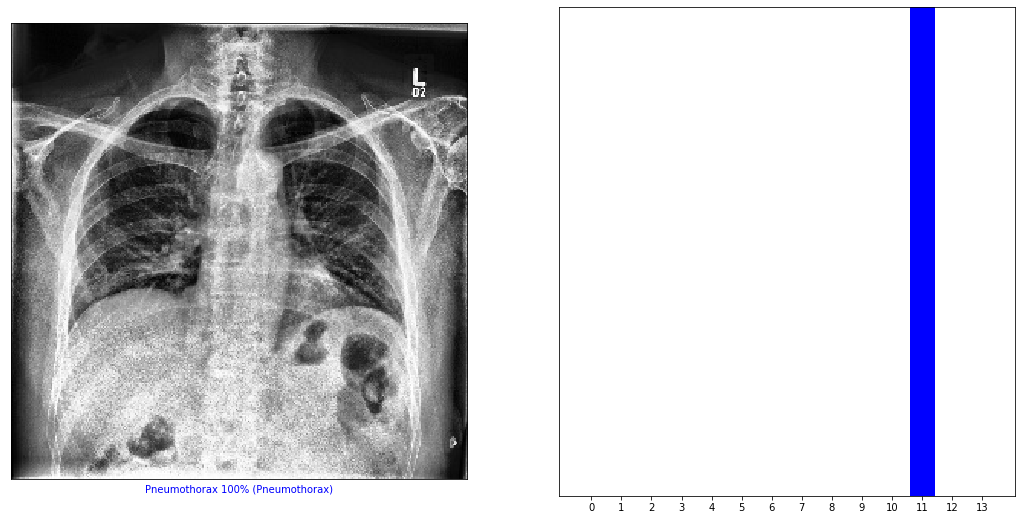

In [37]:
figz = plot_it(true[0], true[0], img[0])

In [38]:
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

In [39]:
plot_to_image(figz)


<tf.Tensor: id=64314, shape=(1, 288, 432, 4), dtype=uint8, numpy=
array([[[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        ...,

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
     

<Figure size 432x288 with 0 Axes>

In [35]:
figz.show()

/home/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.
